# Practical Lesson on Climate Data Analysis 3
### Matteo Mastropierro and Davide Zanchettin


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## High resolution data

We are going to use two high resolution datasets, suitable for climate impact assessment studies.

*   The first is an ERA5 downscaled dataset (available at:https://dds.cmcc.it/#/dataset/era5-downscaled-over-italy?), for the period 1981-2022.

*   The second is a RCP4.5 downscaled climate model projection dataset (https://dds.cmcc.it/#/dataset/climate-projections-rcp85-downscaled-over-italy/historical)

In [2]:
%%capture

%pip install cftime
%pip install cartopy
%pip install icclim

import cftime
import cartopy.crs as ccrs
import icclim

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cftime
import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline
#%config InlineBackend.figure_format='retina'

Load the historical ESM simulation

In [3]:
path = '/content/drive/MyDrive/Climate Data Analysis Lesson/'
file = 'era5-downscaled-over-italy_daily_lonlat.nc'
ds_hist = xr.load_dataset(path+file)
ds_hist

<xarray.Dataset> Size: 202MB
Dimensions:    (time: 15340, bnds: 2, lon: 41, lat: 40)
Coordinates:
  * time       (time) datetime64[ns] 123kB 1981-01-01T11:30:00 ... 2022-12-31...
  * lon        (lon) float64 328B 11.0 11.05 11.1 11.15 ... 12.9 12.95 13.0
  * lat        (lat) float64 320B 44.03 44.08 44.12 44.18 ... 45.88 45.93 45.98
    height_2m  float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 245kB 1980-01-01 ... 1980-01-02T05...
    T_2M       (time, lat, lon) float32 101MB nan 275.5 273.7 ... 282.8 282.8
    TOT_PREC   (time, lat, lon) float32 101MB nan 1.981e-14 ... 0.0 0.0
Attributes: (12/15)
    CDI:             Climate Data Interface version 1.9.9rc1 (https://mpimet....
    Conventions:     CF-1.4
    history:         Wed Dec 06 01:19:04 2023: cdo mergetime era5-downscaled-...
    source:          COSMO
    institution:     CMCC (Euro-Mediterranean Center on Climate Change), REMH...
    title:           cclm-sp_2.4_terra_urb_2.3.1 simulation (0.02 Deg) forced...
    ...              ...
    contact:         Mario Raffa (mario.raffa@cmcc.it)- Marianna Adinolfi (ma...
    references:      http//www.clm-community.eu, http://www.cmcc.it
    creation_date:   2022-10-22 00:28:52
    grid_mapping:    rotated_pole
    frequency:       day
    CDO:             Climate Data Operators version 1.9.9rc1 (https://mpimet....

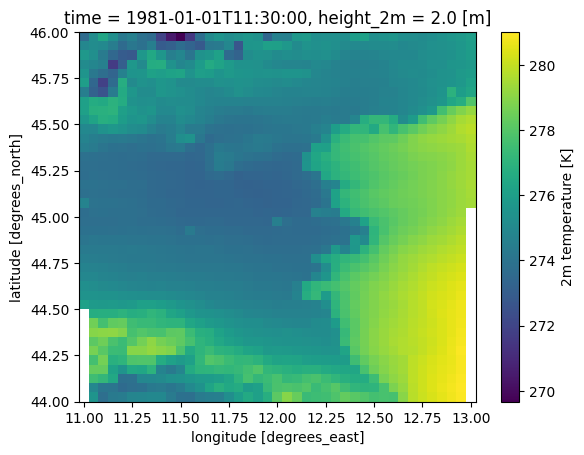

In [4]:
ds_hist.isel(time = 0)["T_2M"].plot()

Load the future (2070-2100) RCP4.5 projections

In [5]:
file = 'VHR-PRO_IT2km_CMCC-CM_rcp45_CCLM5-0-9_day_lonlat.nc'
ds_rcp = xr.load_dataset(path+file)
ds_rcp#.T_2M

<xarray.Dataset> Size: 362MB
Dimensions:    (time: 10227, bnds: 2, lon: 67, lat: 66)
Coordinates:
  * time       (time) datetime64[ns] 82kB 2041-01-01T11:30:00 ... 2070-12-31T...
  * lon        (lon) float64 536B 11.01 11.04 11.07 11.1 ... 12.93 12.96 12.99
  * lat        (lat) float64 528B 44.02 44.05 44.08 44.11 ... 45.92 45.95 45.98
    height_2m  float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 164kB 2005-01-01 ... 2005-01-04T01...
    T_2M       (time, lat, lon) float32 181MB 274.9 275.7 276.9 ... 284.9 284.9
    TOT_PREC   (time, lat, lon) float32 181MB 0.07031 0.06098 ... 0.1254 0.1246
Attributes: (12/14)
    CDI:             Climate Data Interface version 1.9.9rc1 (https://mpimet....
    Conventions:     CF-1.4
    history:         Tue Dec 05 15:57:20 2023: cdo -sellonlatbox,11,13,44,46 ...
    source:          COSMO
    institution:     CMCC (Euro-Mediterranean Center on Climate Change), REMH...
    title:           cclm-sp_2.4_terra_urb_2.3.1 simulation (0.02 Deg) forced...
    ...              ...
    conventionsURL:  http://www.cfconventions.org/
    contact:         Mario Raffa (mario.raffa@cmcc.it)
    references:      http//www.clm-community.eu, http://www.cmcc.it
    creation_date:   2021-04-12 23:17:55
    frequency:       day
    CDO:             Climate Data Operators version 1.9.9rc1 (https://mpimet....

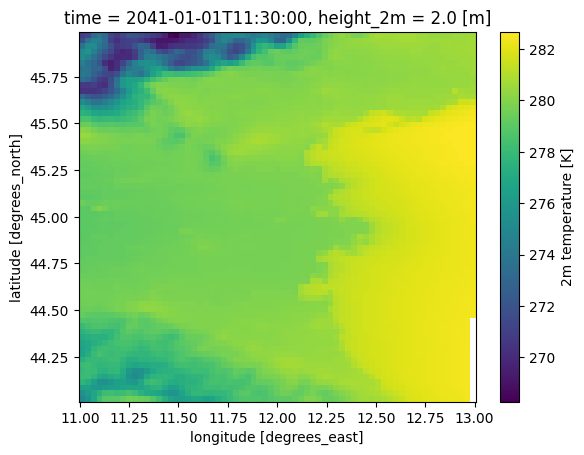

In [6]:
ds_rcp.isel(time = 0)["T_2M"].plot()

In [7]:
# Convert the Temperature Kelvin to Celsius

var = "T_2M"
ds_hist[var] = ds_hist[var] - 273.15
ds_rcp[var] = ds_rcp[var] - 273.15

# Convert the Precipitation amount from kgm-2 to mm/day
# 1kg/m-2 = 86400 mm/day

# var = "TOT_PREC"
# ds_hist[var] = ds_hist[var] * 86400
# ds_rcp[var] = ds_rcp[var] * 86400
# ds_hist[var].attrs["units"] = "mm*day-1"
# ds_rcp[var].attrs["units"] = "mm*day-1"


Let's compute some climate index based on the work of the ETCCDI (https://www.clivar.org/organization/etccdi/etccdi.php).

These indeces have been created in order to diagnose (mainly) extreme events with respect to a specific climatic variable. You can find the list here: https://www.ecad.eu/indicesextremes/indicesdictionary.php.

We will focus on temperature and precipitation indices to see how some aspects of climate have changed at the local scale.

In [8]:
# Set longitude and latitude for a city
# BOLOGNA

lonx=11.20
laty=44.29

### TG90p

**Days when Tmean > 90th percentile**

In [9]:
def TG90p(daily_temperature):
    # Calculate the 90th percentile
    perc90 = daily_temperature.quantile(0.9, dim='time')

    # Sum number of days and get the index at yearly resolution
    TG90p_index = (daily_temperature>perc90).resample(time="Y", label='left').sum(dim = "time")

    return TG90p_index


In [10]:
tg90p_hist_jja = TG90p(ds_hist["T_2M"].sel(time = ds_hist.time.dt.season == "JJA"))
tg90p_hist_djf = TG90p(ds_hist["T_2M"].sel(time = ds_hist.time.dt.season == "DJF"))

Text(0.5, 1.0, 'DJF')

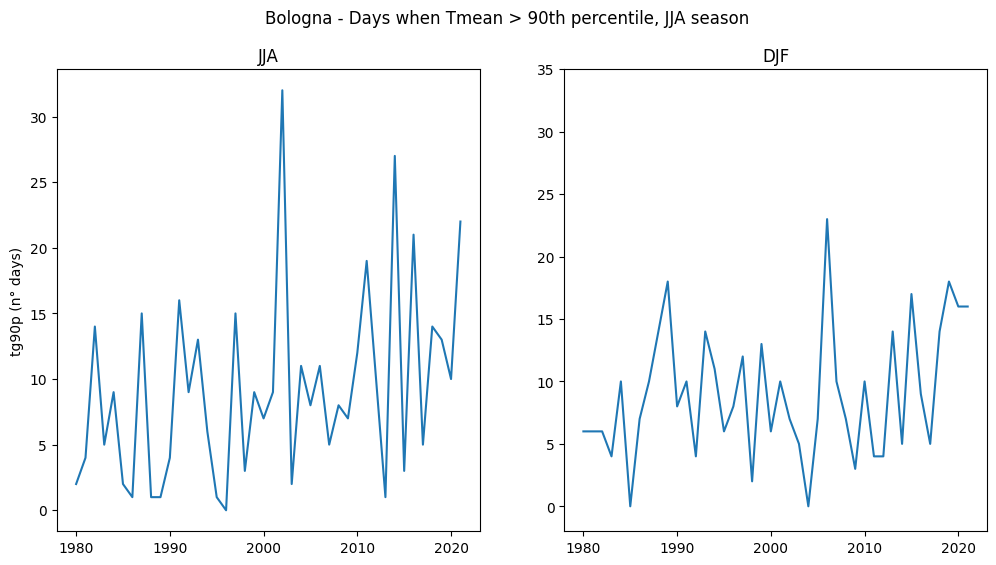

In [11]:
fig = plt.figure(1, figsize=[12,6])
fig.suptitle("Bologna - Days when Tmean > 90th percentile, JJA season")

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# tg90p_hist_jja = tg90p_hist.sel(time = tg90p_hist.time.dt.season == "JJA")
years = tg90p_hist_jja.time.dt.year
ax1.plot(years,
         tg90p_hist_jja.sel(lon=lonx, lat=laty, method="nearest"))
ax2.set_ylim(-2, 35)
ax1.set_title("JJA")
ax1.set_ylabel("tg90p (n° days)")

# tg90p_hist_djf = tg90p_hist.sel(time = tg90p_hist.time.dt.season == "DJF")
ax2.plot(years,
        tg90p_hist_djf.sel(lon=lonx, lat=laty, method="nearest"))
ax2.set_ylim(-2, 35)
ax2.set_title("DJF")


### TG10p

In [12]:
def TG10p(daily_temperature):
    # Calculate the 10th percentile
    perc10 = daily_temperature.quantile(0.1, dim='time')

    # Sum number of days and get the index at yearly resolution
    TG10p_index = (daily_temperature<perc10).resample(time="Y", label='left').sum(dim = "time")

    return TG10p_index


In [13]:
tg10p_hist_jja = TG10p(ds_hist["T_2M"].sel(time = ds_hist.time.dt.season == "JJA"))
tg10p_hist_djf = TG10p(ds_hist["T_2M"].sel(time = ds_hist.time.dt.season == "DJF"))


Text(0.5, 1.0, 'DJF')

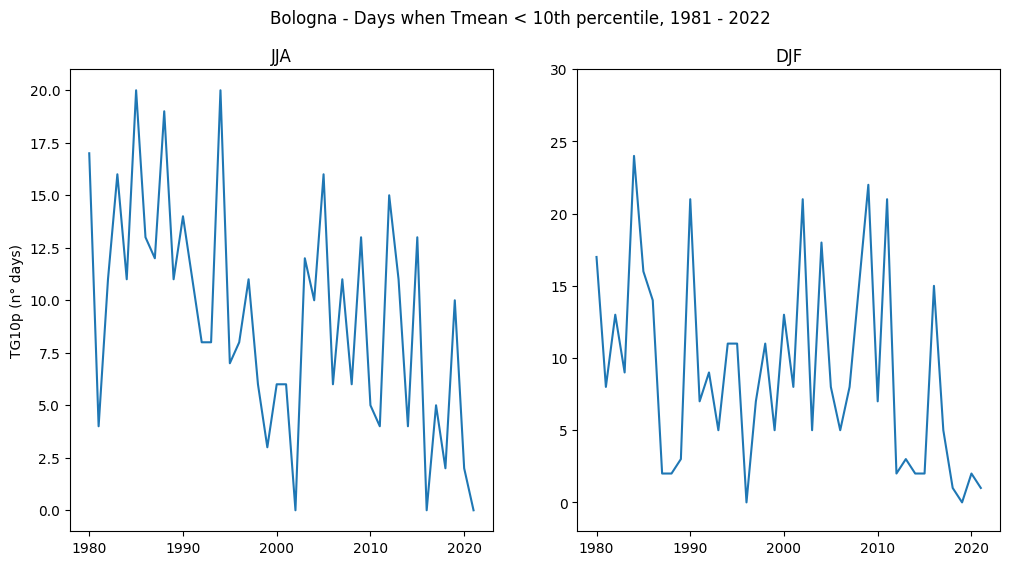

In [14]:
fig = plt.figure(1, figsize=[12,6])
fig.suptitle("Bologna - Days when Tmean < 10th percentile, 1981 - 2022")

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

years = tg10p_hist_jja.time.dt.year
ax1.plot(years,
         tg10p_hist_jja.sel(lon=lonx, lat=laty, method="nearest"))
ax2.set_ylim(-2, 30)
ax1.set_title("JJA")
ax1.set_ylabel("TG10p (n° days)")

years = tg10p_hist_djf.time.dt.year
ax2.plot(years,
        tg10p_hist_djf.sel(lon=lonx, lat=laty, method="nearest"))
ax2.set_ylim(-2, 30)
ax2.set_title("DJF")


Let's examine now the total precipitation amount

### Extreme Precipitation Indeces

**RX90ptot**

In [15]:
def RX90pTOT(daily_precipitation):
    # Calculate the 90th percentile
    perc90 = daily_precipitation.quantile(0.9, dim='time')

    # Calculate total precipitation on very wet days
    total_precipitation_wet_days = (daily_precipitation > perc90).resample(time="Y", label='left').sum(dim = "time")

    # Calculate total precipitation for all days
    total_precipitation_all_days = (daily_precipitation).resample(time="Y", label='left').sum(dim = "time")

    # Calculate RX90pTOT index
    rx90ptot_index = total_precipitation_wet_days / total_precipitation_all_days

    return rx90ptot_index


In [16]:
rx90ptot_hist_jja = RX90pTOT(ds_hist['TOT_PREC'].sel(time = ds_hist.time.dt.season == "JJA"))
rx90ptot_hist_djf = RX90pTOT(ds_hist['TOT_PREC'].sel(time = ds_hist.time.dt.season == "DJF"))

Text(0.5, 1.0, 'DJF')

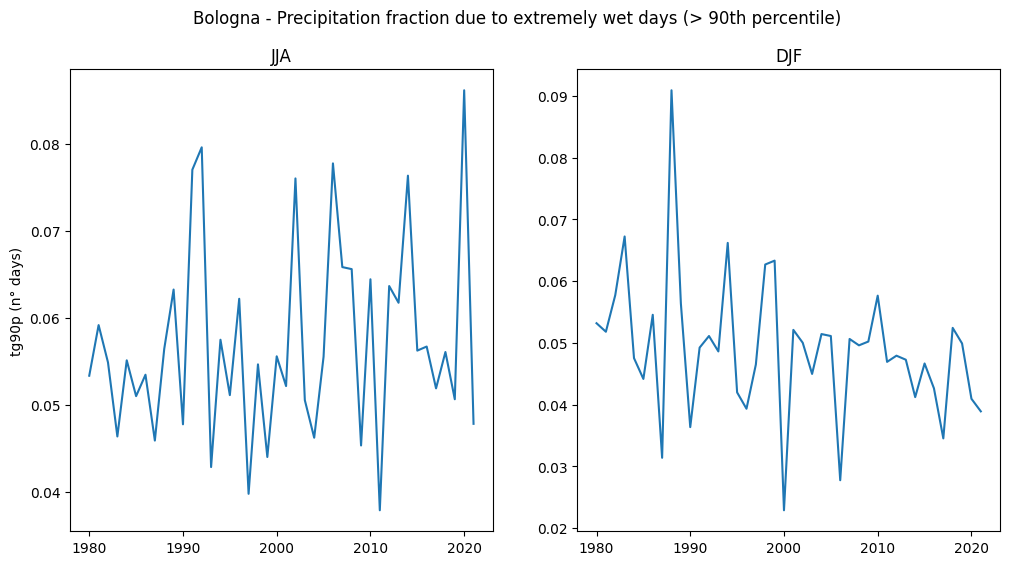

In [17]:
fig = plt.figure(1, figsize=[12,6])
fig.suptitle("Bologna - Precipitation fraction due to extremely wet days (> 90th percentile) ")

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# rx90ptot_hist_jja = tg90p_rcp.sel(time = tg90p_rcp.time.dt.season == "JJA")
years = rx90ptot_hist_jja.time.dt.year
ax1.plot(years,
         rx90ptot_hist_jja.sel(lon=lonx, lat=laty, method="nearest"))
# ax1.set_ylim(-2, 35)
ax1.set_title("JJA")
ax1.set_ylabel("tg90p (n° days)")

# tg90p_rcp_djf = tg90p_rcp.sel(time = tg90p_rcp.time.dt.season == "DJF")
ax2.plot(years,
        rx90ptot_hist_djf.sel(lon=lonx, lat=laty, method="nearest"))
# ax2.set_ylim(-2, 35)
ax2.set_title("DJF")


## Historical vs RCP4.5

Compare the seasonality and the distribution of Temperature and Precipitation in the two periods.

In [18]:
# Convert the Precipitation amount from kgm-2 to mm/day
# 1kg/m-2 = 86400 mm/day

var = "TOT_PREC"
ds_hist[var] = ds_hist[var] * 86400
ds_rcp[var] = ds_rcp[var] * 86400
ds_hist[var].attrs["units"] = "mm*day-1"
ds_rcp[var].attrs["units"] = "mm*day-1"


In [19]:
seas_hist_t2m = ds_hist.T_2M.groupby("time.month").mean(dim = "time")
seas_rcp_t2m = ds_rcp.T_2M.groupby("time.month").mean(dim = "time")

In [20]:
test = ds_rcp.TOT_PREC.groupby("time.month").sum(dim = 'time')*(1/24)#.mean(dim = "time")
test2 = ds_hist.TOT_PREC.groupby("time.month").sum(dim = 'time')*(1/24)#.mean(dim = "time")

Text(0.5, 1.0, 'Precipitation')

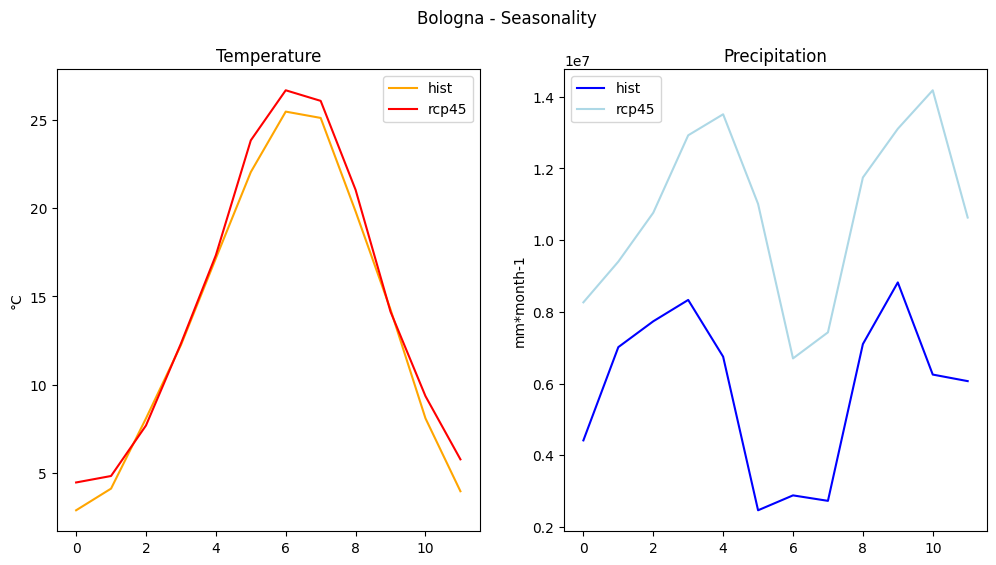

In [21]:
fig = plt.figure(1, figsize=[12,6])
fig.suptitle("Bologna - Seasonality")

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.plot(seas_hist_t2m.sel(lon = lonx, lat = laty, method = "nearest"), color = "orange")
ax1.plot(seas_rcp_t2m.sel(lon = lonx, lat = laty, method = "nearest"), color = "red")
ax1.legend(["hist", "rcp45"])

# ax1.set_ylim(-2, 35)
ax1.set_title("Temperature")
ax1.set_ylabel("°C")

ax2.plot(test.sel(lon = lonx, lat = laty, method = "nearest"), color = "blue")
ax2.plot(test2.sel(lon = lonx, lat = laty, method = "nearest"), color = "lightblue")
ax2.legend(["hist", "rcp45"])

# ax2.set_ylim(-2, 35)
ax2.set_ylabel("mm*month-1")
ax2.set_title("Precipitation")
